In [1]:
#Simple nu-O event generator for 10s-of-MeV neutrinos
#Follows approach taken by NEWTON
#
#Steps:
# Supply total xs (different choices)
# Supply partial xs, normalize to total
# Specify neutrino flux, fold with XS, sample
# Sample partial xs based on sampled neutrino energy
# Calculate lepton energy, direction, nuclear recoil
# Draw from pre-computed TALYS de-excitation files to generate events
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #Just for printing table of coefficients nicely
from matplotlib.colors import LogNorm

interpolationStep_MeV = 0.1 #Interpolate digitized plots with this precision
maxEnergy_MeV = 52.9
energies_MeV_interp = np.arange(0,maxEnergy_MeV,interpolationStep_MeV)

#total_xs_name = "data/total_xs/Haxton1987.csv"
total_xs_name = "data/total_xs/Kolbe2002.csv"

partial_xs_name = "data/partial_xs/Nakazato2018.csv"
outputFormat = "root" #root, ascii

#Constants
#AME 20 mass evaluations: https://www.anl.gov/sites/www/files/2021-05/mass_1.mas20.txt
mass_16O_amu = 15994914.61926e-6 #includes 8 electrons
mass_16F_amu = 16011460.278e-6 #includes 9 electrons
amu_to_MeV = 931.49432

#(160 + 8 electrons) + nu_e -> (16F + 8 electrons) + 1 electron 
threshold = (mass_16F_amu-mass_16O_amu)*amu_to_MeV
print(f"Threshold of 16O CC process is {threshold:.3f} MeV")

Threshold of 16O CC process is 15.412 MeV


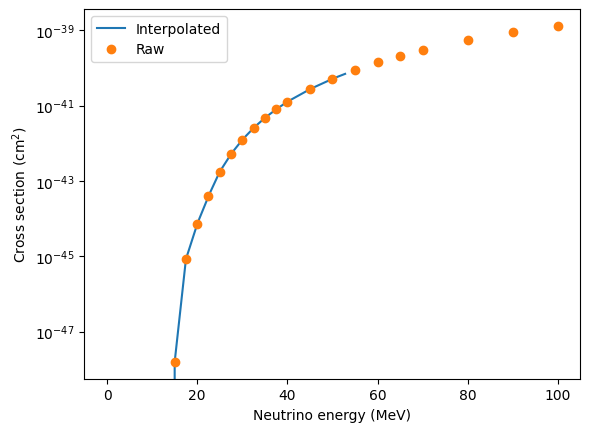

In [2]:
#1. Load total xs
def loadCSV(fname):
  energies_MeV_raw = []
  xs_cm2_raw = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==2:
          energies_MeV_raw.append(float(lineParts[0]))
          xs_cm2_raw.append(float(lineParts[1]))
  

  return energies_MeV_raw,xs_cm2_raw

energies_MeV_raw,xs_cm2_raw = loadCSV(total_xs_name)

logxs_cm2_raw = np.log10(xs_cm2_raw)
logxs_interp = np.interp(energies_MeV_interp, energies_MeV_raw, logxs_cm2_raw,left=-np.inf,right=logxs_cm2_raw[-1])
xs_cm2_interp = np.power(10,logxs_interp)

#xs_cm2_interp = np.interp(energies_MeV_interp,energies_MeV_raw,xs_cm2_raw,left=0,right=xs_cm2_raw[-1])

plt.plot(energies_MeV_interp,xs_cm2_interp,label="Interpolated")
plt.plot(energies_MeV_raw,xs_cm2_raw,ls="",marker="o",label="Raw")
plt.legend()
plt.xlabel("Neutrino energy (MeV)")
plt.ylabel("Cross section (cm$^2$)")
plt.yscale("log")


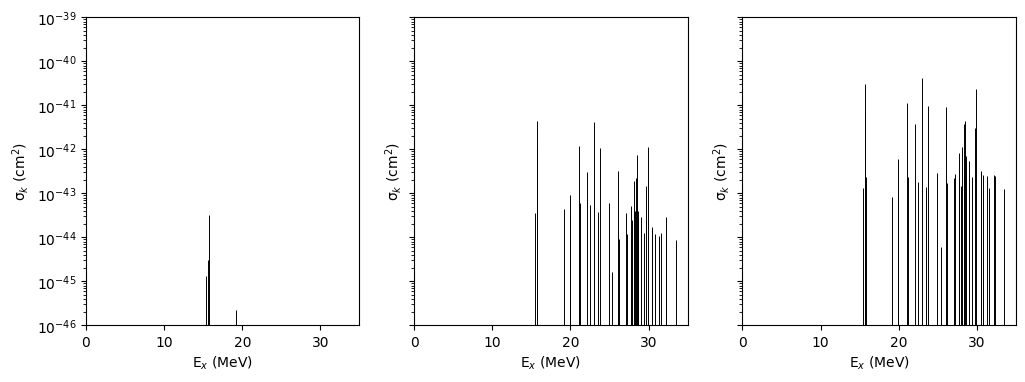

In [3]:
#Load partial cross sections
def loadNazakatoData(fname):
  excitedLevels_MeV = []
  excitedLevels_J = []
  excitedLevels_parity = []
  excitedXS_20MeV = []
  excitedXS_40MeV = []
  excitedXS_60MeV = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==6:
          excitedLevels_MeV.append(float(lineParts[0]))
          excitedLevels_J.append(int(lineParts[1]))
          excitedLevels_parity.append(int(lineParts[2]))
          excitedXS_20MeV.append(float(lineParts[3]))
          excitedXS_40MeV.append(float(lineParts[4]))
          excitedXS_60MeV.append(float(lineParts[5]))
  
  #FIT COEFFICIENTS
  excitedLevels_MeV = np.asarray(excitedLevels_MeV)
  excitedXS_20MeV = np.asarray(excitedXS_20MeV)
  excitedXS_40MeV = np.asarray(excitedXS_40MeV)
  excitedXS_60MeV = np.asarray(excitedXS_60MeV)

  return excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV
  
excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV = loadNazakatoData(partial_xs_name)

#Make 3 plots of xs vs. excitation energy 
fig,ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
Exs_MeV = excitedLevels_MeV + threshold

mask = excitedXS_20MeV > 0
ax[0].vlines(Exs_MeV[mask], 1e-46, excitedXS_20MeV[mask],color="k",lw=0.7)
mask = excitedXS_40MeV > 0
ax[1].vlines(Exs_MeV[mask], 1e-46, excitedXS_40MeV[mask],color="k",lw=0.7)
mask = excitedXS_60MeV > 0
ax[2].vlines(Exs_MeV[mask], 1e-46, excitedXS_60MeV[mask],color="k",lw=0.7)

plt.yscale("log")
ax[0].set_xlim(0,35)
ax[0].set_xlabel("E$_x$ (MeV)")
ax[0].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[0].set_ylim(1e-46,1e-39)

ax[1].set_xlim(0,35)
ax[1].set_xlabel("E$_x$ (MeV)")
ax[1].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[1].set_ylim(1e-46,1e-39)

ax[2].set_xlim(0,35)
ax[2].set_xlabel("E$_x$ (MeV)")
ax[2].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[2].set_ylim(1e-46,1e-39)
plt.show()


In [4]:
#Solve for coefficients
def solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV):
  c1s = []
  c2s = []
  c3s = []
  #Now step through levels, computing nu xs by fitting the three data files to determine coefficients a,b,c. Then
  for ilev,Ex in enumerate(Exs_MeV):

    if Ex < 20:
      Lambda_20MeV = np.log10(np.power(20,0.25)-np.power(Ex,0.25))
    else:
      Lambda_20MeV = 0
    if Ex < 40:
      Lambda_40MeV = np.log10(np.power(40,0.25)-np.power(Ex,0.25))
    else:
      Lambda_40MeV = 0
    if Ex < 60:
      Lambda_60MeV = np.log10(np.power(60,0.25)-np.power(Ex,0.25))
    else:
      Lambda_60MeV = 0

    if excitedXS_20MeV[ilev]>0:
      logxs_20MeV = np.log10(excitedXS_20MeV[ilev])
    else:
      logxs_20MeV =  -np.inf
    if excitedXS_40MeV[ilev]>0:
      logxs_40MeV = np.log10(excitedXS_40MeV[ilev])
    else:
      logxs_40MeV = -np.inf
    if excitedXS_60MeV[ilev]>0:
      logxs_60MeV = np.log10(excitedXS_60MeV[ilev])
    else:
      logxs_60MeV = -np.inf

    if logxs_20MeV==-np.inf:
      A = np.array([[1.0,Lambda_40MeV],
                  [1.0,Lambda_60MeV]])
      y = np.array([logxs_40MeV,logxs_60MeV])
      a,b = np.linalg.solve(A,y)
      c = 0
    else:
      A = np.array([[1.0,Lambda_20MeV,Lambda_20MeV*Lambda_20MeV],
                  [1.0,Lambda_40MeV,Lambda_40MeV*Lambda_40MeV],
                  [1.0,Lambda_60MeV,Lambda_60MeV*Lambda_60MeV]])
      y = np.array([logxs_20MeV,logxs_40MeV,logxs_60MeV])
      a,b,c = np.linalg.solve(A,y)

    c1s.append(a)
    c2s.append(b)
    c3s.append(c)

  return c1s,c2s,c3s
  
c1s,c2s,c3s = solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV)

df = pd.DataFrame({
    "Excited level (MeV)": excitedLevels_MeV+threshold,
    "a": c1s,
    "b": c2s,
    "c": c3s,
})

df
      


,Excited level (MeV),a,b,c
0,15.412187,-42.543052,3.588841,1.041581
1,15.662187,-40.665080,5.014967,0.839990
2,15.712187,-39.982873,5.327749,1.615245
3,15.752187,-41.637786,9.822896,0.000000
4,19.172187,-42.915559,1.026265,-0.383861
5,19.922187,-41.600813,3.616534,0.000000
6,19.932187,-42.691018,2.053455,0.000000
7,21.072187,-40.161886,4.085200,0.000000
8,21.192187,-42.125895,2.539773,0.000000
9,22.122187,-40.509726,4.354531,0.000000


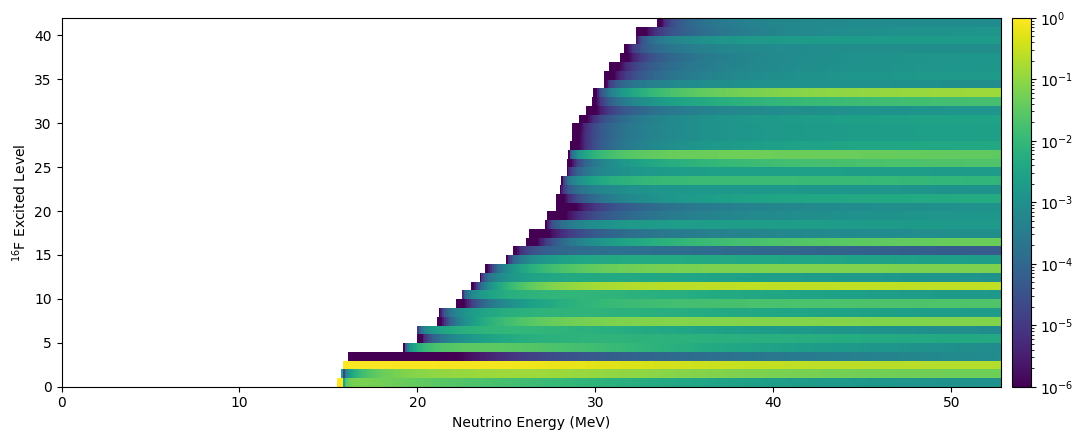

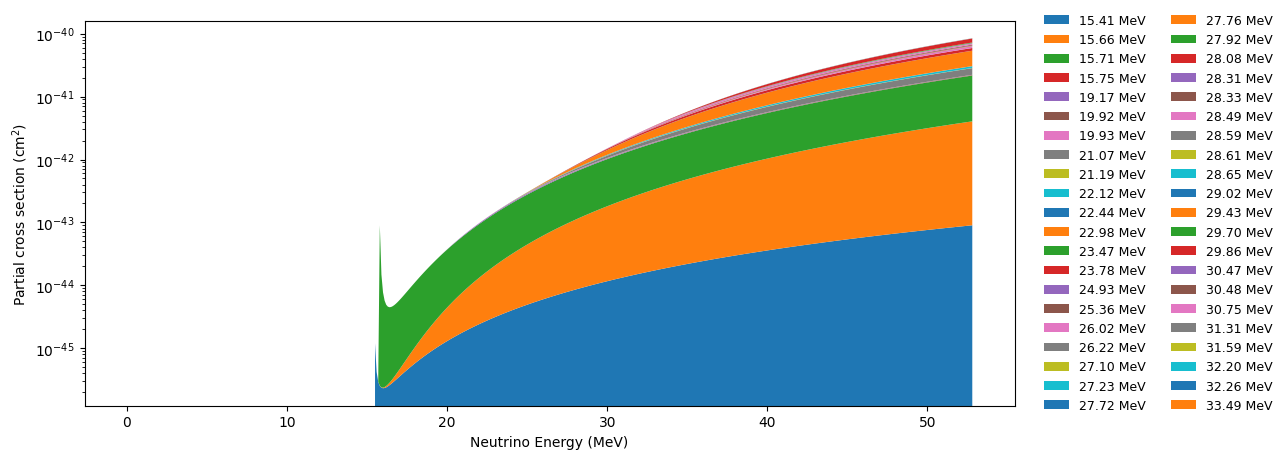

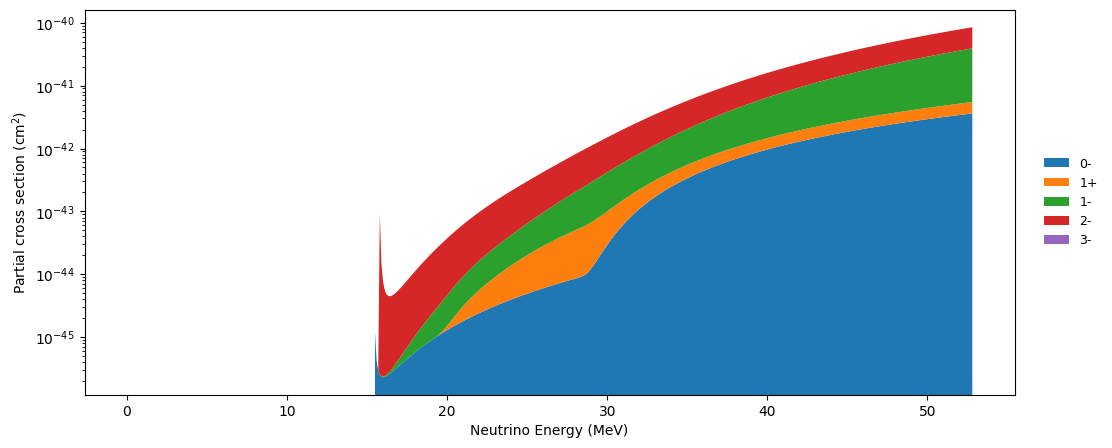

In [26]:
#Now calculate partial_xs
eps_MeV = 0.0

partial_xs = []
for ilev,Ex_MeV in enumerate(Exs_MeV):
  xs = np.zeros_like(energies_MeV_interp)
  if c3s[ilev]==0:
    for inrg,E in enumerate(energies_MeV_interp):
      if E<=Ex_MeV + eps_MeV:
        continue
      Lam = np.log10(np.power(E,0.25)-np.power(Ex_MeV,0.25))
      log10XS = c1s[ilev] + c2s[ilev]*Lam
      xs[inrg] = np.power(10,log10XS)
  else:
    for inrg,E in enumerate(energies_MeV_interp):
      if E<=Ex_MeV + eps_MeV:
        continue
      Lam = np.log10(np.power(E,0.25)-np.power(Ex_MeV,0.25))
      log10XS = c1s[ilev] + c2s[ilev]*Lam + c3s[ilev]*Lam*Lam
      xs[inrg] = np.power(10,log10XS)
  
  partial_xs.append(xs)


#############################
##Compare with Baran's plot##
#############################
Z = np.vstack([np.asarray(xs) for xs in partial_xs])
#Convert to probabilities
colsum = Z.sum(axis=0)                                
probs = np.zeros_like(Z, dtype=float)
nonzero_mask = colsum > 0
probs[:, nonzero_mask] = Z[:, nonzero_mask] / colsum[nonzero_mask]

# Plot: y-axis is uniform "level index" bins; labels show actual excited levels (optional)
fig, ax = plt.subplots(figsize=(12, 4.5))

im = ax.imshow(
    probs,
    origin="lower",
    aspect="auto",
    interpolation="nearest",
    norm=LogNorm(vmin=1e-6, vmax=1.0),
    extent=[energies_MeV_interp[0],
            energies_MeV_interp[-1],
            0,
            probs.shape[0]]
)

ax.set_xlabel("Neutrino Energy (MeV)")
ax.set_ylabel("$^{16}$F Excited Level")
cbar = plt.colorbar(im, ax=ax, pad=0.01)
plt.tight_layout()

#####################
##Plot exclusive xs##
#####################
fig2,ax2 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in partial_xs])   # (nlev, nE)

labels = [f"{Exs_MeV[i]:.2f} MeV" for i in range(xs_stack.shape[0])]

ax2.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax2.set_xlabel("Neutrino Energy (MeV)")
ax2.set_ylabel(r"Partial cross section (cm$^2$)")
ax2.set_yscale("log")

ax2.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    ncol=2,                      # number of columns (adjust as needed)
    fontsize=9,
    frameon=False
)

##################
##Multipole plot##
##################
JPis = np.array([f"{J}{'+' if p > 0 else '-'}"
                 for J, p in zip(excitedLevels_J, excitedLevels_parity)])
multipoles = np.unique(JPis)
multipole_xs=[np.zeros_like(energies_MeV_interp) for _ in multipoles]
for mi, multipole in enumerate(multipoles):
    indices = np.where(JPis == multipole)[0]
    for idx in indices:
        multipole_xs[mi] += partial_xs[idx]    # <-- add into the right bucket


fig3,ax3 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in multipole_xs])   # (nMultipoles, nE)
labels = list(multipoles)

ax3.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax3.set_xlabel("Neutrino Energy (MeV)")
ax3.set_ylabel(r"Partial cross section (cm$^2$)")
ax3.set_yscale("log")

ax3.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    fontsize=9,
    frameon=False
)

plt.show()